# Autotalker Batch Integration Mouse Organogenesis Imputed

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 20.01.2023
- **Date of Last Modification:** 07.03.2023

## 1. Setup

### 1.1 Import Libraries

In [ ]:
2+3

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../autotalker")

In [3]:
import argparse
import os
import pickle
import random
import warnings
from copy import deepcopy
from datetime import datetime

import anndata as ad
# import bbknn
import matplotlib
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import scanpy as sc
# import scarches as sca
import scib
import scipy.sparse as sp
import scvi
import seaborn as sns
import squidpy as sq
import torch
from matplotlib.pyplot import rc_context
# from scarches.models.sagenet.utils import glasso
from sklearn.decomposition import KernelPCA

from autotalker.benchmarking import compute_clisis, compute_cas
from autotalker.models import Autotalker
from autotalker.utils import (add_gps_from_gp_dict_to_adata,
                              extract_gp_dict_from_mebocost_es_interactions,
                              extract_gp_dict_from_nichenet_ligand_target_mx,
                              extract_gp_dict_from_omnipath_lr_interactions,
                              filter_and_combine_gp_dict_gps,
                              get_unique_genes_from_gp_dict)

[rank: 0] Global seed set to 0
/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/omnipath/_core/query/_query_validator.py:165: ResourceWarning: unclosed <ssl.SSLSocket fd=44, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('10.233.0.146', 34738), raddr=('178.62.7.222', 443)>
  res = Downloader(opt).maybe_download(
/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/omnipath/_core/query/_query_validator.py:165: ResourceWarning: unclosed <ssl.SSLSocket fd=44, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('10.233.0.146', 34754), raddr=('178.62.7.222', 443)>
  res = Downloader(opt).maybe_download(
/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/omnipath/_core/query/_query_validator.py:165: ResourceWarning: unclosed <ssl.SSLSocket fd=44, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('10.233.0.146', 34758), raddr=('178.62.7.222', 4

In [4]:
# Set experiment
experiment = mlflow.set_experiment("batch_integration_mouse_organogenesis_imputed")

/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 1.2 Define Parameters

In [5]:
## Dataset
dataset = "seqfish_mouse_organogenesis"
batch1 = "embryo1_z2"
batch2 = "embryo1_z5"
batch3 = "embryo2_z2"
batch4 = "embryo2_z5"
batch5 = "embryo3_z2"
batch6 = "embryo3_z5"
n_neighbors = 15 # 4, 8, 12, 16, 20
n_hvg_genes = 2000 # 4000

## Model
# AnnData Keys
counts_key = "log_normalized_counts" # raw counts not available
cell_type_key = "celltype_mapped_refined"
adj_key = "spatial_connectivities"
spatial_key = "spatial"
gp_names_key = "autotalker_gp_names"
active_gp_names_key = "autotalker_active_gp_names"
gp_targets_mask_key = "autotalker_gp_targets"
gp_sources_mask_key = "autotalker_gp_sources"
latent_key = "autotalker_latent"
condition_key = "batch"
mapping_entity_key = "mapping_entity"

# Architecture
active_gp_thresh_ratio = 0.03 # 0.01
gene_expr_recon_dist = "nb" # zinb
n_cond_embed = 180
log_variational = False # log normalized counts as input
n_layers_encoder = 1
conv_layer_encoder = "gcnconv" # gatv2conv gcnconv

# Trainer
n_epochs = 40 # 40
n_epochs_all_gps = 20 # 20
lr = 0.001
query_cond_embed_lr = 0.01
lambda_edge_recon = 1000. # 0.3 # 1., 0.01
lambda_gene_expr_recon = 1. # 1. # 1., 0.01, 0.0033
lambda_group_lasso = 0.1 # 0.01
lambda_l1_masked = 0.1 # 0.01 0.0033
edge_batch_size = 128 # 64, 128, 256, 512
node_batch_size = 16 # 8, 16, 32, 64

# Benchmarking
spatial_knng_key = "autotalker_spatial_knng"
latent_knng_key = "autotalker_latent_knng"

## Others
random_seed = 42
load_timestamp = None

### 1.3 Run Notebook Setup

In [6]:
sc.set_figure_params(figsize=(6, 6))
sns.set_style("whitegrid", {'axes.grid' : False})

/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


In [7]:
# Ignore future warnings and user warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [8]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
mlflow.log_param("timestamp", current_timestamp)

'07032023_191420'

### 1.4 Configure Paths and Create Directories

In [10]:
# Define paths
figure_folder_path = f"../figures/{dataset}/batch_integration/{current_timestamp}"
model_artifacts_folder_path = f"../artifacts/{dataset}/batch_integration/{current_timestamp}"
gp_data_folder_path = "../datasets/gp_data" # gene program data
srt_data_folder_path = "../datasets/srt_data" # spatially resolved transcriptomics data
srt_data_gold_folder_path = f"{srt_data_folder_path}/gold"
nichenet_ligand_target_mx_file_path = gp_data_folder_path + "/nichenet_ligand_target_matrix.csv"
omnipath_lr_interactions_file_path = gp_data_folder_path + "/omnipath_lr_interactions.csv"

# Create required directories
os.makedirs(figure_folder_path, exist_ok=True)
os.makedirs(model_artifacts_folder_path, exist_ok=True)

/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 2. Data

### 2.1 Load Data

In [11]:
adata_original = ad.read_h5ad(f"{srt_data_gold_folder_path}/{dataset}_imputed.h5ad")

In [12]:
# Use log normalized counts as raw counts are not available
adata_original.layers[counts_key] = adata_original.X

/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 2.2 Prepare Data & GP Mask

#### 2.2.1 Filter Genes Based on GP Mask & HVG

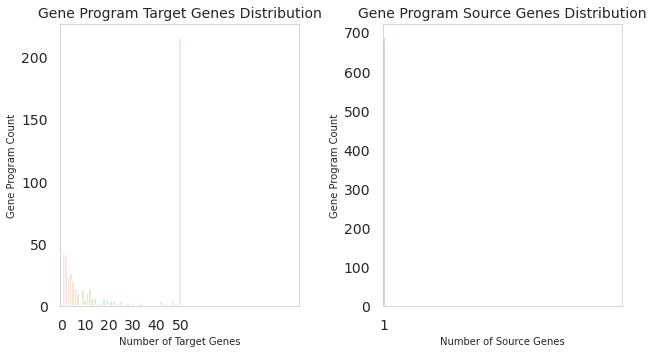

In [13]:
nichenet_gp_dict = extract_gp_dict_from_nichenet_ligand_target_mx(
    keep_target_genes_ratio=0.01,
    max_n_target_genes_per_gp=50,
    load_from_disk=False,
    save_to_disk=False,
    file_path=nichenet_ligand_target_mx_file_path,
    plot_gp_gene_count_distributions=True)

/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


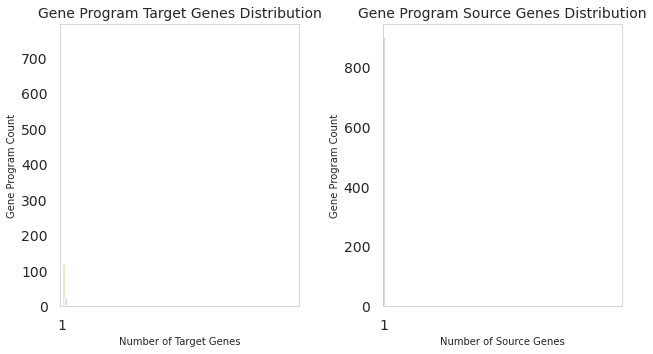

In [14]:
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    min_curation_effort=0,
    load_from_disk=False,
    save_to_disk=False,
    file_path=omnipath_lr_interactions_file_path,
    plot_gp_gene_count_distributions=True)

/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


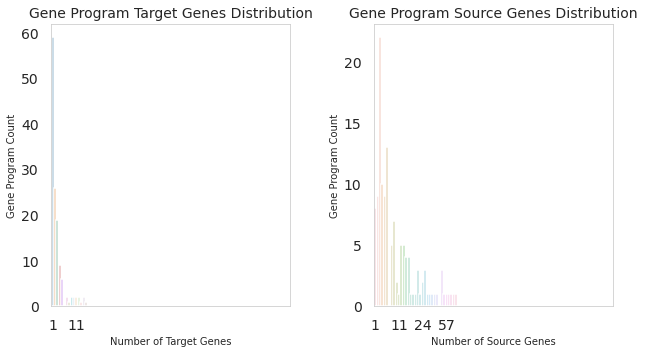

In [15]:
mebocost_gp_dict = extract_gp_dict_from_mebocost_es_interactions(
    dir_path=f"{gp_data_folder_path}/metabolite_enzyme_sensor_gps/",
    species="mouse",
    genes_uppercase=True,
    plot_gp_gene_count_distributions=True)

In [16]:
# Combine gene programs into one dictionary
combined_gp_dict = dict(nichenet_gp_dict)
combined_gp_dict.update(omnipath_gp_dict)
# combined_gp_dict.update(mebocost_gp_dict)

/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
# Filter and combine gene programs
combined_new_gp_dict = filter_and_combine_gp_dict_gps(
    gp_dict=combined_gp_dict,
    gp_filter_mode="subset",
    combine_overlap_gps=True,
    overlap_thresh_source_genes=0.9,
    overlap_thresh_target_genes=0.9,
    overlap_thresh_genes=0.9,
    verbose=True)

print(f"Number of gene programs before filtering and combining: {len(combined_gp_dict)}.")
print(f"Number of gene programs after filtering and combining: {len(combined_new_gp_dict)}.")

Removing GP 'TNFSF4_ligand_receptor_GP' as it is a subset of GP 'TNFSF4_ligand_targetgenes_GP'.
Removing GP 'TGFB1_ligand_receptor_GP' as it is a subset of GP 'TGFB1_ligand_targetgenes_GP'.
Removing GP 'BMP2_ligand_receptor_GP' as it is a subset of GP 'BMP2_ligand_targetgenes_GP'.
Removing GP 'EDN1_ligand_receptor_GP' as it is a subset of GP 'EDN1_ligand_targetgenes_GP'.
Removing GP 'EDN3_ligand_receptor_GP' as it is a subset of GP 'EDN3_ligand_targetgenes_GP'.
Removing GP 'GCG_ligand_receptor_GP' as it is a subset of GP 'GCG_ligand_targetgenes_GP'.
Removing GP 'HCRT_ligand_receptor_GP' as it is a subset of GP 'HCRT_ligand_targetgenes_GP'.
Removing GP 'GRP_ligand_receptor_GP' as it is a subset of GP 'GRP_ligand_targetgenes_GP'.
Removing GP 'NTF3_ligand_receptor_GP' as it is a subset of GP 'NTF3_ligand_targetgenes_GP'.
Removing GP 'AVP_ligand_receptor_GP' as it is a subset of GP 'AVP_ligand_targetgenes_GP'.
Removing GP 'PROK1_ligand_receptor_GP' as it is a subset of GP 'PROK1_ligand_tar

In [18]:
# Filter genes and only keep ligand, receptor, metabolitye enzyme, metabolite sensor and 
# highly variable genes (potential target genes of nichenet)
gp_dict_genes = get_unique_genes_from_gp_dict(gp_dict=combined_new_gp_dict,
                                              retrieved_gene_entities=["sources", "targets"])

omnipath_genes = get_unique_genes_from_gp_dict(gp_dict=omnipath_gp_dict,
                                               retrieved_gene_entities=["sources", "targets"])

mebocost_genes = get_unique_genes_from_gp_dict(gp_dict=mebocost_gp_dict,
                                               retrieved_gene_entities=["sources", "targets"])

nichenet_source_genes = get_unique_genes_from_gp_dict(gp_dict=nichenet_gp_dict,
                                                      retrieved_gene_entities=["sources"])

# gp_relevant_genes = list(set(omnipath_genes + mebocost_genes + nichenet_source_genes))
gp_relevant_genes = list(set(omnipath_genes + nichenet_source_genes))

# Keep only highly variable genes
sc.pp.highly_variable_genes(
    adata_original,
    n_top_genes=n_hvg_genes,
    batch_key="batch",
    subset=False)

adata_original.var["gp_relevant"] = adata_original.var.index.str.upper().isin(gp_relevant_genes)
adata_original.var["keep_gene"] = adata_original.var["gp_relevant"] | adata_original.var["highly_variable"]
adata_original = adata_original[:, adata_original.var["keep_gene"] == True]
print(f"Keeping {len(adata_original.var_names)} highly variable or gene program relevant genes.")
adata_original = adata_original[:, adata_original.var_names[adata_original.var_names.str.upper().isin(gp_dict_genes)].sort_values()]
print(f"Keeping {len(adata_original.var_names)} genes after filtering genes not in gp dict.")
adata_original = adata_original[:, (adata_original.X.sum(axis=0) > 0)]
print(f"Keeping {len(adata_original.var_names)} genes after removing genes with 0 expression.")
adata = adata_original.copy()

Keeping 3058 highly variable or gene program relevant genes.
Keeping 1769 genes after filtering genes not in gp dict.
Keeping 1651 genes after removing genes with 0 expression.


In [19]:
# Split adata into different batches
adata_batch1 = adata[adata.obs["batch"] == batch1].copy() # reference
adata_batch2 = adata[adata.obs["batch"] == batch2].copy() # reference
adata_batch3 = adata[adata.obs["batch"] == batch3].copy() # reference
adata_batch4 = adata[adata.obs["batch"] == batch4].copy() # reference
adata_batch5 = adata[adata.obs["batch"] == batch5].copy() # query
adata_batch6 = adata[adata.obs["batch"] == batch6].copy() # query

adata_batch_list = [adata_batch1,
                    adata_batch2,
                    adata_batch3,
                    adata_batch4,
                    adata_batch5,
                    adata_batch6]

/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 2.3 Compute Spatial Neighbor Graphs

In [20]:
for i in range(len(adata_batch_list)):
    # Compute (separate) spatial neighborhood
    sq.gr.spatial_neighbors(adata_batch_list[i],
                            coord_type="generic",
                            spatial_key=spatial_key,
                            n_neighs=n_neighbors)
    # Make adjacency matrix symmetric
    adata_batch_list[i].obsp[adj_key] = adata_batch_list[i].obsp[adj_key].maximum(
        adata_batch_list[i].obsp[adj_key].T)

### 2.4 Combine Data for One-Shot Batch Integration

In [21]:
adata_one_shot = ad.concat(adata_batch_list, join="inner")

# Combine spatial neighborhood graphs as disconnected components
connectivities_extension_batch1 = sp.csr_matrix((adata_batch_list[0].shape[0],
                                                 (adata_batch_list[1].shape[0] +
                                                  adata_batch_list[2].shape[0] +
                                                  adata_batch_list[3].shape[0] +
                                                  adata_batch_list[4].shape[0] +
                                                  adata_batch_list[5].shape[0])))
connectivities_extension_batch2_before = sp.csr_matrix((adata_batch_list[1].shape[0],
                                                        adata_batch_list[0].shape[0]))
connectivities_extension_batch2_after = sp.csr_matrix((adata_batch_list[1].shape[0],
                                                       (adata_batch_list[2].shape[0] +
                                                        adata_batch_list[3].shape[0] +
                                                        adata_batch_list[4].shape[0] +
                                                        adata_batch_list[5].shape[0])))
connectivities_extension_batch3_before = sp.csr_matrix((adata_batch_list[2].shape[0],
                                                        (adata_batch_list[0].shape[0] +
                                                         adata_batch_list[1].shape[0])))
connectivities_extension_batch3_after = sp.csr_matrix((adata_batch_list[2].shape[0],
                                                       (adata_batch_list[3].shape[0] +
                                                        adata_batch_list[4].shape[0] +
                                                        adata_batch_list[5].shape[0])))
connectivities_extension_batch4_before = sp.csr_matrix((adata_batch_list[3].shape[0],
                                                        (adata_batch_list[0].shape[0] +
                                                         adata_batch_list[1].shape[0] +
                                                         adata_batch_list[2].shape[0])))
connectivities_extension_batch4_after = sp.csr_matrix((adata_batch_list[3].shape[0],
                                                       (adata_batch_list[4].shape[0] +
                                                        adata_batch_list[5].shape[0])))
connectivities_extension_batch5_before = sp.csr_matrix((adata_batch_list[4].shape[0],
                                                        (adata_batch_list[0].shape[0] +
                                                         adata_batch_list[1].shape[0] +
                                                         adata_batch_list[2].shape[0] +
                                                         adata_batch_list[3].shape[0])))
connectivities_extension_batch5_after = sp.csr_matrix((adata_batch_list[4].shape[0],
                                                       adata_batch_list[5].shape[0]))
connectivities_extension_batch6 = sp.csr_matrix((adata_batch_list[5].shape[0],
                                                 (adata_batch_list[0].shape[0] +
                                                  adata_batch_list[1].shape[0] +
                                                  adata_batch_list[2].shape[0] +
                                                  adata_batch_list[3].shape[0] +
                                                  adata_batch_list[4].shape[0])))

connectivities_batch1 = sp.hstack((adata_batch_list[0].obsp[adj_key],
                                   connectivities_extension_batch1))
connectivities_batch2 = sp.hstack((connectivities_extension_batch2_before,
                                   adata_batch_list[1].obsp[adj_key],
                                   connectivities_extension_batch2_after))
connectivities_batch3 = sp.hstack((connectivities_extension_batch3_before,
                                   adata_batch_list[2].obsp[adj_key],
                                   connectivities_extension_batch3_after))
connectivities_batch4 = sp.hstack((connectivities_extension_batch4_before,
                                   adata_batch_list[3].obsp[adj_key],
                                   connectivities_extension_batch4_after))
connectivities_batch5 = sp.hstack((connectivities_extension_batch5_before,
                                   adata_batch_list[4].obsp[adj_key],
                                   connectivities_extension_batch5_after))
connectivities_batch6 = sp.hstack((connectivities_extension_batch6,
                                   adata_batch_list[5].obsp[adj_key]))

connectivities = sp.vstack((connectivities_batch1,
                            connectivities_batch2,
                            connectivities_batch3,
                            connectivities_batch4,
                            connectivities_batch5,
                            connectivities_batch6))

adata_one_shot.obsp[adj_key] = connectivities

/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 2.5 Combine Data for Query-to-Reference Mapping

In [22]:
# Reference
adata_reference = ad.concat(adata_batch_list[:-2], join="inner")

# Combine spatial neighborhood graphs as disconnected components
connectivities_extension_batch1 = sp.csr_matrix((adata_batch_list[0].shape[0],
                                                 (adata_batch_list[1].shape[0] +
                                                  adata_batch_list[2].shape[0] +
                                                  adata_batch_list[3].shape[0])))
connectivities_extension_batch2_before = sp.csr_matrix((adata_batch_list[1].shape[0],
                                                        adata_batch_list[0].shape[0]))
connectivities_extension_batch2_after = sp.csr_matrix((adata_batch_list[1].shape[0],
                                                       (adata_batch_list[2].shape[0] +
                                                        adata_batch_list[3].shape[0])))
connectivities_extension_batch3_before = sp.csr_matrix((adata_batch_list[2].shape[0],
                                                        (adata_batch_list[0].shape[0] +
                                                         adata_batch_list[1].shape[0])))
connectivities_extension_batch3_after = sp.csr_matrix((adata_batch_list[2].shape[0],
                                                       (adata_batch_list[3].shape[0])))
connectivities_extension_batch4 = sp.csr_matrix((adata_batch_list[3].shape[0],
                                                 (adata_batch_list[0].shape[0] +
                                                  adata_batch_list[1].shape[0] +
                                                  adata_batch_list[2].shape[0])))

connectivities_batch1 = sp.hstack((adata_batch_list[0].obsp[adj_key],
                                   connectivities_extension_batch1))
connectivities_batch2 = sp.hstack((connectivities_extension_batch2_before,
                                   adata_batch_list[1].obsp[adj_key],
                                   connectivities_extension_batch2_after))
connectivities_batch3 = sp.hstack((connectivities_extension_batch3_before,
                                   adata_batch_list[2].obsp[adj_key],
                                   connectivities_extension_batch3_after))
connectivities_batch4 = sp.hstack((connectivities_extension_batch4,
                                   adata_batch_list[3].obsp[adj_key]))

connectivities = sp.vstack((connectivities_batch1,
                            connectivities_batch2,
                            connectivities_batch3,
                            connectivities_batch4))

adata_reference.obsp[adj_key] = connectivities

/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
# Query
adata_query = ad.concat(adata_batch_list[-2:], join="inner")

# Combine spatial neighborhood graphs as disconnected components
connectivities_extension_batch5 = sp.csr_matrix((adata_batch_list[4].shape[0],
                                                 (adata_batch_list[5].shape[0])))
connectivities_extension_batch6 = sp.csr_matrix((adata_batch_list[5].shape[0],
                                                 (adata_batch_list[4].shape[0])))

connectivities_batch5 = sp.hstack((adata_batch_list[4].obsp[adj_key],
                                   connectivities_extension_batch5))
connectivities_batch6 = sp.hstack((connectivities_extension_batch6,
                                   adata_batch_list[5].obsp[adj_key]))

connectivities = sp.vstack((connectivities_batch5,
                            connectivities_batch6))

adata_query.obsp[adj_key] = connectivities

/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
adata_reference_query = adata_one_shot.copy()

# Add mapping entity 
reference_batches = adata_reference.obs[condition_key].unique().tolist()
query_batches = adata_query.obs[condition_key].unique().tolist()
adata_reference_query.obs[mapping_entity_key] = None
adata_reference_query.obs.loc[adata_reference_query.obs[condition_key].isin(reference_batches), mapping_entity_key] = "reference"
adata_reference_query.obs.loc[adata_reference_query.obs[condition_key].isin(query_batches), mapping_entity_key] = "query"

/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 2.6 Add GP Mask to Data

In [25]:
for adata in adata_batch_list + [adata_one_shot, adata_reference, adata_query, adata_reference_query]:
    # Add the gene program dictionary as binary masks to the adata for model training
    add_gps_from_gp_dict_to_adata(
        gp_dict=combined_new_gp_dict,
        adata=adata,
        genes_uppercase=True,
        gp_targets_mask_key=gp_targets_mask_key,
        gp_sources_mask_key=gp_sources_mask_key,
        gp_names_key=gp_names_key,
        min_genes_per_gp=1,
        min_source_genes_per_gp=0,
        min_target_genes_per_gp=0,
        max_genes_per_gp=None,
        max_source_genes_per_gp=None,
        max_target_genes_per_gp=None,
        filter_genes_not_in_masks=False)

# Determine dimensionality of hidden encoder
n_hidden_encoder = len(adata_one_shot.uns[gp_names_key])

# Summarize gene programs
print(f"Number of gene programs with probed genes: {len(adata_one_shot.uns[gp_names_key])}.")
print(f"Example gene programs: {random.sample(list(adata_one_shot.uns[gp_names_key]), 5)}.")
print(f"Number of gene program target genes: {adata_one_shot.varm[gp_targets_mask_key].sum()}.")
print(f"Number of gene program source genes: {adata_one_shot.varm[gp_sources_mask_key].sum()}.")

/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Number of gene programs with probed genes: 1429.
Example gene programs: ['PLG_ligand_receptor_GP', 'TNFSF12_ligand_targetgenes_GP', 'RET_ligand_targetgenes_GP', 'TF_ligand_receptor_GP', 'S100A8_ligand_receptor_GP'].
Number of gene program target genes: 5902.
Number of gene program source genes: 1128.


## 3. Model Training

### 3.1 Batch Integration Baselines

In [ ]:
### TO DO ###

#### 3.1.1 scVI

In [ ]:
scvi.settings.seed = random_seed
    
# Setup adata
scvi.model.SCVI.setup_anndata(adata_one_shot,
                              layer=counts_key,
                              batch_key=condition_key)

# Initialize model
# Use hyperparams that provenly work well on integration tasks (https://docs.scvi-tools.org/en/stable/tutorials/notebooks/harmonization.html)
vae = scvi.model.SCVI(adata_one_shot,
                      n_layers=2,
                      n_latent=30,
                      gene_likelihood="nb")

# Train model
vae.train()

adata_one_shot.obsm["scvi_latent"] = vae.get_latent_representation()

In [ ]:
# Use scVI latent space for UMAP generation
sc.pp.neighbors(adata_one_shot, use_rep="scvi_latent")
sc.tl.umap(adata_one_shot)

In [ ]:
# Plot UMAP with batch annotations
fig = sc.pl.umap(adata_one_shot,
                 color=[cell_type_key],
                 legend_fontsize=12,
                 return_fig=True)
plt.title("scVI Integration: Latent Space Cell Type Annotations", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_cell_types_scvi.png",
            bbox_inches="tight")

#### 3.1.2 SageNet

In [ ]:
#################################################################
This cell throws an error as the solver cannot solve this problem
#################################################################


# Construct gene interaction network for spatial references
for i in range(len(adata_batch_list[:-2])):
    adata_batch_list[i].X = adata_batch_list[i].X.toarray() # convert to dense matrix as required by glasso
    print("Computing gene interaction network...")
    glasso(adata_batch_list[i], [0.25, 0.5])
    adata_batch_list[i].X = sp.csc_matrix(adata_batch_list[i].X) # convert back to sparse matrix
    print("Computing Leiden clusters...")
    sc.tl.leiden(adata_batch_list[i],
                 resolution=.05,
                 random_state=random_seed,
                 key_added="leiden_0.05",
                 adjacency=adata_batch_list[i].obsp["spatial_connectivities"])
    sc.tl.leiden(adata_batch_list[i],
                 resolution=.1,
                 random_state=random_seed,
                 key_added="leiden_0.1",
                 adjacency=adata_batch_list[i].obsp["spatial_connectivities"])
    sc.tl.leiden(adata_batch_list[i],
                 resolution=.5,
                 random_state=random_seed,
                 key_added="leiden_0.5",
                 adjacency=adata_batch_list[i].obsp["spatial_connectivities"])

In [ ]:
if torch.cuda.is_available():
  dev = "cuda:0"
else:
  dev = "cpu"
device = torch.device(dev)
print(device)

In [ ]:
# Define model object
sg_obj = sca.models.sagenet(device=device)

In [ ]:
# Train model on spatial references
for i in range(len(adata_batch_list[:-2])):
    sg_obj.train(adata_batch_list[i],
                 comm_columns=['leiden_0.05', 'leiden_0.1', 'leiden_0.5'],
                 tag=f'batch{i}',
                 epochs=15,
                 verbose = False,
                 importance=True)

In [ ]:
# Save model
os.makedirs(model_artifacts_folder_path + "/sagenet")
sg_obj.save_as_folder(model_artifacts_folder_path + "/sagenet")

In [ ]:
# Load model
sg_obj_load = sca.models.sagenet(device=device)
sg_obj_load.load_from_folder(model_artifacts_folder_path + "/sagenet")

In [ ]:
# Load query
sg_obj_load.load_query_data(adata)

In [ ]:
# Use SageNet cell-cell-distances for UMAP generation
sc.pp.neighbors(adata, use_rep="dist_map")
sc.tl.umap(adata)

In [ ]:
# Plot UMAP with batch annotations
fig = sc.pl.umap(adata,
                 color=[condition_key],
                 legend_fontsize=12,
                 return_fig=True)
plt.title("SageNet Integration: Latent Space Batch Annotations", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_batches_sagenet.png",
            bbox_inches="tight")

In [ ]:
# Plot UMAP with cell type annotations
fig = sc.pl.umap(adata,
                 color=[cell_type_key],
                 return_fig=True)
plt.title("SageNet: Latent Space Cell Type Annotations", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_cell_types_sagenet.png",
            bbox_inches="tight")

#### 3.1.3 BBKNN

In [ ]:
latent_bbknn_list = []
for i in range(len(adata_batch_list)):
    # Initialize model
    model = Autotalker(adata_batch_list[i],
                       counts_key=counts_key,
                       adj_key=adj_key,
                       condition_key=condition_key,
                       cond_embed_injection=["encoder",
                                             "gene_expr_decoder",
                                             "graph_decoder"],
                       n_cond_embed=n_cond_embed,
                       gp_names_key=gp_names_key,
                       active_gp_names_key=active_gp_names_key,
                       gp_targets_mask_key=gp_targets_mask_key,
                       gp_sources_mask_key=gp_sources_mask_key,
                       latent_key=latent_key,
                       active_gp_thresh_ratio=0., # all gps will be active for concatenation across batches
                       gene_expr_recon_dist=gene_expr_recon_dist,
                       n_hidden_encoder=n_hidden_encoder,
                       log_variational=True)
    print("")
    
    # Train model
    model.train(n_epochs=n_epochs,
                n_epochs_all_gps=n_epochs, # all gps will be active for concatenation across batches
                lr=lr,
                lambda_edge_recon=lambda_edge_recon,
                lambda_gene_expr_recon=lambda_gene_expr_recon,
                verbose=True)
    print("")
    
    # Save trained model
    model.save(dir_path=model_artifacts_folder_path + f"/bbknn_batch{i+1}",
               overwrite=True,
               save_adata=True,
               adata_file_name=f"{dataset}.h5ad")
    
    latent_bbknn_current_batch = model.get_latent_representation(
        adata=adata_batch_list[i],
        counts_key=counts_key,
        condition_key=condition_key,
        only_active_gps=False)
    
    latent_bbknn_list.append(latent_bbknn_current_batch)
    
adata_bbknn.obsm[latent_key] = np.vstack(latent_bbknn_list)

# Store adata to disk
adata_bbknn.write(f"{model_artifacts_folder_path}/adata_bbknn.h5ad")

In [ ]:
if load_timestamp is not None:
    model_artifacts_load_folder_path = f"../artifacts/{dataset}/batch_integration/{load_timestamp}"
else:
    model_artifacts_load_folder_path = model_artifacts_folder_path

# Read adata from disk
adata_bbknn = sc.read_h5ad(f"{model_artifacts_load_folder_path}/adata_bbknn.h5ad")

In [ ]:
# Compute batch-corrected latent nearest neighbor graph
bbknn.bbknn(adata=adata_bbknn,
            batch_key=condition_key,
            use_rep=latent_key)

adata_bbknn.obsp[f"{latent_knng_key}_connectivities"] = (
    adata_bbknn.obsp["connectivities"])

adata_bbknn.obsp[f"{latent_knng_key}_distances"] = (
    adata_bbknn.obsp["distances"])

In [ ]:
# Use batch-corrected latent space for UMAP generation
sc.tl.umap(adata_bbknn)

In [ ]:
# Plot UMAP with batch annotations
fig = sc.pl.umap(adata_bbknn,
                 color=[condition_key],
                 legend_fontsize=12,
                 return_fig=True)
plt.title("BBKNN Integration: Latent Space Batch Annotations", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_batches_bbknn.png",
            bbox_inches="tight")

In [ ]:
# Plot UMAP with cell type annotations
fig = sc.pl.umap(adata_bbknn,
                 color=[cell_type_key],
                 return_fig=True)
plt.title("BBKNN Integration: Latent Space Cell Type Annotations", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_cell_types_bbknn.png",
            bbox_inches="tight")

In [ ]:
# Compute spatial nearest neighbor graph
sc.pp.neighbors(adata_bbknn, use_rep=spatial_key, key_added=spatial_knng_key)

In [ ]:
metrics_dict_bbknn = {}

metrics_dict_bbknn["cad"] = compute_cad(
    adata=adata_bbknn,
    cell_type_key=cell_type_key,
    spatial_knng_key=spatial_knng_key,
    latent_knng_key=latent_knng_key)

metrics_dict_bbknn["rclisi"] = compute_rclisi(
    adata=adata_bbknn,
    cell_type_key=cell_type_key,
    spatial_knng_key=spatial_knng_key,
    latent_knng_key=latent_knng_key)
    
metrics_dict_bbknn["batch_asw"] = scib.me.silhouette_batch(
    adata=adata_bbknn,
    batch_key=condition_key,
    label_key=cell_type_key,
    embed="X_umap")

# knn output
metrics_dict_bbknn["ilisi"] = scib.me.ilisi_graph(
    adata=adata_bbknn,
    batch_key=condition_key,
    type_="knn")

"""
metrics_dict_bbknn["kbet"] = scib.me.kBET(
    adata=adata_bbknn,
    batch_key=condition_key,
    label_key=cell_type_key,
    type_="knn")
"""

print(metrics_dict_bbknn)

# Store to disk
with open(f"{model_artifacts_folder_path}/metrics_bbknn.pickle", "wb") as f:
    pickle.dump(metrics_dict_bbknn, f)

### 3.2 One-Shot Batch Integration

#### 3.2.1 Initialize, Train & Save Model

In [26]:
# Initialize model
model = Autotalker(adata_one_shot,
                   counts_key=counts_key,
                   adj_key=adj_key,
                   condition_key=condition_key,
                   cond_embed_injection=["gene_expr_decoder",
                                         "graph_decoder"],
                   n_cond_embed=n_cond_embed,
                   gp_names_key=gp_names_key,
                   active_gp_names_key=active_gp_names_key,
                   gp_targets_mask_key=gp_targets_mask_key,
                   gp_sources_mask_key=gp_sources_mask_key,
                   latent_key=latent_key,
                   active_gp_thresh_ratio=active_gp_thresh_ratio,
                   gene_expr_recon_dist=gene_expr_recon_dist,
                   n_layers_encoder=n_layers_encoder,
                   conv_layer_encoder=conv_layer_encoder,
                   n_hidden_encoder=n_hidden_encoder,
                   log_variational=log_variational)

/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb
NODE LABEL METHOD -> one-hop-attention
ACTIVE GP THRESHOLD RATIO -> 0.03
LOG VARIATIONAL -> False
CONDITIONAL EMBEDDING INJECTION -> ['gene_expr_decoder', 'graph_decoder']
GRAPH ENCODER -> n_input: 1651, n_cond_embed_input: 0, n_layers: 1, n_hidden: 1429, n_latent: 1429, n_addon_latent: 0, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0
COSINE SIM GRAPH DECODER -> n_cond_embed_input: 180, n_output: 1429, dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 1429, n_cond_embed_input: 180, n_addon_input: 0, n_output: 3302


In [ ]:
# Train model
model.train(n_epochs,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=lr,
            lambda_edge_recon=lambda_edge_recon,
            lambda_gene_expr_recon=lambda_gene_expr_recon,
            lambda_group_lasso=lambda_group_lasso,
            lambda_l1_masked=lambda_l1_masked,
            edge_batch_size=edge_batch_size,
            node_batch_size=node_batch_size,
            mlflow_experiment_id=experiment.experiment_id,
            verbose=True)

--- INITIALIZING TRAINER ---
Number of training nodes: 47311
Number of validation nodes: 5257
Number of training edges: 398043
Number of validation edges: 44226

--- MODEL TRAINING ---
Epoch 1/40 |--------------------| 2.5% val_auroc_score: 0.9750; val_auprc_score: 0.9740; val_best_acc_score: 0.9151; val_best_f1_score: 0.9169; train_kl_reg_loss: 0.9905; train_edge_recon_loss: 157.6563; train_gene_expr_recon_loss: 549.8915; train_masked_gp_l1_reg_loss: 3.4713; train_group_lasso_reg_loss: 2.0141; train_global_loss: 714.0237; train_optim_loss: 714.0237; val_kl_reg_loss: 0.7547; val_edge_recon_loss: 156.7391; val_gene_expr_recon_loss: 497.4374; val_masked_gp_l1_reg_loss: 3.5850; val_group_lasso_reg_loss: 2.0868; val_global_loss: 660.6030; val_optim_loss: 660.6030
Epoch 2/40 |█-------------------| 5.0% val_auroc_score: 0.9753; val_auprc_score: 0.9738; val_best_acc_score: 0.9155; val_best_f1_score: 0.9176; train_kl_reg_loss: 1.2143; train_edge_recon_loss: 152.6948; train_gene_expr_recon_loss

In [ ]:
# Save trained model
model.save(dir_path=model_artifacts_folder_path + "/oneshot",
           overwrite=True,
           save_adata=True,
           adata_file_name=f"{dataset}.h5ad")

#### 3.2.2 Load & Save Model with UMAP Features

In [ ]:
if load_timestamp is not None:
    model_artifacts_load_folder_path = f"../artifacts/{dataset}/batch_integration/{load_timestamp}"
else:
    model_artifacts_load_folder_path = model_artifacts_folder_path

# Load trained model
model = Autotalker.load(dir_path=model_artifacts_load_folder_path + "/oneshot",
                        adata=None,
                        adata_file_name=f"{dataset}.h5ad",
                        gp_names_key="autotalker_gp_names")

In [ ]:
# Compute latent nearest neighbor graph
sc.pp.neighbors(model.adata,
                use_rep=latent_key,
                key_added=latent_knng_key)

# Use Autotalker latent space for UMAP generation
sc.tl.umap(model.adata,
           neighbors_key=latent_knng_key)

In [ ]:
# Save trained model
model.save(dir_path=model_artifacts_folder_path + "/oneshot",
           overwrite=True,
           save_adata=True,
           adata_file_name=f"{dataset}.h5ad")

In [ ]:
# Save adata
model.adata.write(f"{model_artifacts_folder_path}/{dataset}_oneshot.h5ad")

#### 3.2.3 Visualize Latent Space

In [ ]:
# Plot UMAP with batch annotations
fig = sc.pl.umap(model.adata,
                 color=[condition_key],
                 legend_fontsize=12,
                 return_fig=True)
plt.title("One-Shot Integration: Latent Space Batch Annotations", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_batches_oneshot.png",
            bbox_inches="tight")

In [ ]:
# Plot UMAP with cell type annotations
fig = sc.pl.umap(model.adata,
                 color=[cell_type_key],
                 return_fig=True)
plt.title("One-Shot Integration: Latent Space Cell Type Annotations", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_cell_types_oneshot.png",
            bbox_inches="tight")

In [ ]:
# Check number of active gene programs
active_gps = model.get_active_gps()
print(f"Number of total gene programs: {len(model.adata.uns[gp_names_key])}.")
print(f"Number of active gene programs: {len(active_gps)}.")

In [ ]:
gp_summary_df = model.get_gp_summary()
gp_summary_df[gp_summary_df["gp_active"] == True]

#### 3.2.4 Compute Metrics

In [ ]:
# Store computed latent nearest neighbor graph in connectivities
# as required by scib metrics
model.adata.obsp["connectivities"] = (
    model.adata.obsp[f"{latent_knng_key}_connectivities"])
model.adata.obsp["distances"] = (
    model.adata.obsp[f"{latent_knng_key}_distances"])
model.adata.uns["neighbors"] = (
    model.adata.uns[f"{latent_knng_key}"])

# Compute spatial nearest neighbor graph
sc.pp.neighbors(model.adata,
                use_rep=spatial_key,
                key_added=spatial_knng_key)

In [ ]:
# Compute metrics
metrics_dict_oneshot = {}

# Spatial conservation metrics
metrics_dict_oneshot["cas"] = compute_cas(
    adata=model.adata,
    cell_type_key=cell_type_key,
    spatial_knng_key=spatial_knng_key,
    latent_knng_key=latent_knng_key)
metrics_dict_oneshot["clisis"] = compute_clisis(
    adata=model.adata,
    cell_type_key=cell_type_key,
    spatial_knng_key=spatial_knng_key,
    latent_knng_key=latent_knng_key)
    
# Batch correction metrics
metrics_dict_oneshot["batch_asw"] = scib.me.silhouette_batch(
    adata=model.adata,
    batch_key=condition_key,
    label_key=cell_type_key,
    embed="X_umap")
metrics_dict_oneshot["ilisi"] = scib.me.ilisi_graph(
    adata=model.adata,
    batch_key=condition_key,
    type_="knn")

print(metrics_dict_oneshot)

# Store metrics to disk
with open(f"{model_artifacts_folder_path}/metrics_oneshot.pickle", "wb") as f:
    pickle.dump(metrics_dict_oneshot, f)

#### 3.2.5 Visualize Conditional Embedding

In [ ]:
# Get conditional embeddings
cond_embed = model.get_cond_embeddings()
cond = model.adata.obs["batch"].unique()

# Get top 2 principal components and plot them
pca = KernelPCA(n_components=2, kernel="linear")
cond_embed_pca = pca.fit_transform(cond_embed)
sns.scatterplot(x=cond_embed_pca[:, 0], 
                y=cond_embed_pca[:, 1], 
                hue=cond)
plt.title("One-Shot Integration Conditional Embeddings", pad=15)
plt.xlabel("Principal Component 1")
plt.xticks(fontsize=12)
plt.ylabel ("Principal Component 2")
plt.yticks(fontsize=12)
plt.legend(bbox_to_anchor=(1.02, 0.75),
           loc=2,
           borderaxespad=0.,
           fontsize=12,
           frameon=False)
plt.savefig(f"{figure_folder_path}/cond_embed_oneshot.png",
            bbox_inches="tight")

### 3.3 Query-to-Reference Mapping

#### 3.3.1 Building the Reference

##### 3.3.1.1 Initialize, Train & Save Model

In [ ]:
# Initialize model
model = Autotalker(adata_reference,
                   counts_key=counts_key,
                   adj_key=adj_key,
                   condition_key=condition_key,
                   cond_embed_injection=["encoder",
                                         "gene_expr_decoder",
                                         "graph_decoder"],
                   n_cond_embed=n_cond_embed,
                   gp_names_key=gp_names_key,
                   active_gp_names_key=active_gp_names_key,
                   gp_targets_mask_key=gp_targets_mask_key,
                   gp_sources_mask_key=gp_sources_mask_key,
                   latent_key=latent_key,
                   active_gp_thresh_ratio=active_gp_thresh_ratio,
                   gene_expr_recon_dist=gene_expr_recon_dist,
                   n_hidden_encoder=n_hidden_encoder,
                   log_variational=log_variational)

In [ ]:
# Train model
model.train(n_epochs,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=lr,
            lambda_edge_recon=lambda_edge_recon,
            lambda_gene_expr_recon=lambda_gene_expr_recon,
            lambda_l1_masked=lambda_l1_masked,
            edge_batch_size=edge_batch_size,
            node_batch_size=node_batch_size,
            verbose=True)

In [ ]:
# Save trained model
model.save(dir_path=model_artifacts_folder_path + "/reference",
           overwrite=True,
           save_adata=True,
           adata_file_name=f"{dataset}.h5ad")

##### 3.3.1.2 Load Model

In [ ]:
if load_timestamp is not None:
    model_artifacts_load_folder_path = f"../artifacts/{dataset}/batch_integration/{load_timestamp}"
else:
    model_artifacts_load_folder_path = model_artifacts_folder_path

# Load trained model
model = Autotalker.load(dir_path=model_artifacts_load_folder_path + "/reference",
                        adata=None,
                        adata_file_name=f"{dataset}.h5ad",
                        gp_names_key="autotalker_gp_names")

##### 3.3.1.3 Visualize Latent Space

In [ ]:
# Use Autotalker latent space for UMAP generation
sc.pp.neighbors(model.adata, use_rep=latent_key)
sc.tl.umap(model.adata)

In [ ]:
# Plot UMAP with batch annotations
fig = sc.pl.umap(model.adata,
                 color=[condition_key],
                 legend_fontsize=12,
                 return_fig=True)
plt.title("Reference: Latent Space Batch Annotations", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_batches_reference.png",
            bbox_inches="tight")

In [ ]:
# Plot UMAP with cell type annotations
fig = sc.pl.umap(model.adata,
                 color=[cell_type_key],
                 return_fig=True)
plt.title("Reference: Latent Space Cell Type Annotations", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_cell_types_reference.png",
            bbox_inches="tight")

#### 3.3.2 Mapping the Query

##### 3.3.2.1 Initialize, Train & Save Model

In [ ]:
if load_timestamp is not None:
    model_artifacts_load_folder_path = f"../artifacts/{dataset}/batch_integration/{load_timestamp}"
else:
    model_artifacts_load_folder_path = model_artifacts_folder_path

# Load model trained on reference data for transfer learning with query data    
# Freeze all weights except for conditional weights
model = Autotalker.load(dir_path=model_artifacts_load_folder_path + "/reference",
                        adata=adata_query,
                        adata_file_name=f"{dataset}.h5ad",
                        gp_names_key="autotalker_gp_names",
                        unfreeze_all_weights=False,
                        unfreeze_cond_embed_weights=True)

In [ ]:
# Train model
model.train(n_epochs,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=query_cond_embed_lr,
            lambda_edge_recon=lambda_edge_recon,
            lambda_gene_expr_recon=lambda_gene_expr_recon,
            lambda_l1_masked=lambda_l1_masked,
            verbose=True)

In [ ]:
# Save trained model
model.save(dir_path=model_artifacts_folder_path + "/query",
           overwrite=True,
           save_adata=True,
           adata_file_name=f"{dataset}.h5ad")

##### 3.3.2.2 Load & Save Model with Full Dataset & UMAP Features

In [ ]:
if load_timestamp is not None:
    model_artifacts_load_folder_path = f"../artifacts/{dataset}/batch_integration/{load_timestamp}"
else:
    model_artifacts_load_folder_path = model_artifacts_folder_path

# Load trained model
model = Autotalker.load(dir_path=model_artifacts_load_folder_path + "/query",
                        adata=adata_reference_query,
                        adata_file_name=f"{dataset}.h5ad",
                        gp_names_key="autotalker_gp_names")

In [ ]:
# Store latent representation
model.adata.obsm[latent_key] = model.get_latent_representation(
    counts_key=counts_key,
    condition_key=condition_key)

In [ ]:
# Store active gene programs
model.adata.uns[active_gp_names_key] = model.get_active_gps()

In [ ]:
# Compute latent nearest neighbor graph
sc.pp.neighbors(model.adata,
                use_rep=latent_key,
                key_added=latent_knng_key)

# Use Autotalker latent space for UMAP generation
sc.tl.umap(model.adata,
           neighbors_key=latent_knng_key)

# Compute spatial nearest neighbor graph
sc.pp.neighbors(model.adata,
                use_rep=spatial_key,
                key_added=spatial_knng_key)

In [ ]:
# Save trained model
model.save(dir_path=model_artifacts_folder_path + "/reference_query",
           overwrite=True,
           save_adata=True,
           adata_file_name=f"{dataset}.h5ad")

In [ ]:
# Save adata
model.adata.write(f"{model_artifacts_folder_path}/{dataset}_integrated.h5ad")

##### 3.3.2.3 Visualize Latent Space

In [ ]:
# Plot UMAP with batch annotations
fig = sc.pl.umap(model.adata,
                 color=[condition_key],
                 legend_fontsize=12,
                 return_fig=True)
plt.title("Reference + Query: Latent Space Batch Annotations", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_batches_reference_query.png",
            bbox_inches="tight")

In [ ]:
# Plot UMAP with mapping entity annotations
fig = sc.pl.umap(model.adata,
                 color=[mapping_entity_key],
                 legend_fontsize=12,
                 return_fig=True)
plt.title("Reference + Query: Latent Space Mapping Entity Annotations", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_mapping_entities_reference_query.png",
            bbox_inches="tight") 

In [ ]:
# Plot UMAP with cell type annotations
fig = sc.pl.umap(model.adata,
                 color=[cell_type_key],
                 return_fig=True)
plt.title("Reference + Query: Latent Space Cell Type Annotations", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_cell_types_reference_query.png",
            bbox_inches="tight")

##### 3.3.2.4 Compute Metrics

In [ ]:
# Compute metrics
metrics_dict_reference_query = {}

# Spatial conservation metrics
metrics_dict_reference_query["cad"] = compute_cad(
    adata=model.adata,
    cell_type_key=cell_type_key,
    spatial_knng_key=spatial_knng_key,
    latent_knng_key=latent_knng_key)
metrics_dict_reference_query["rclisi"] = compute_rclisi(
    adata=model.adata,
    cell_type_key=cell_type_key,
    spatial_knng_key=spatial_knng_key,
    latent_knng_key=latent_knng_key)
    
# Batch correction metrics
metrics_dict_reference_query["batch_asw"] = scib.me.silhouette_batch(
    adata=model.adata,
    batch_key=condition_key,
    label_key=cell_type_key,
    embed=latent_key)
metrics_dict_reference_query["ilisi"] = scib.me.ilisi_graph(
    adata=model.adata,
    batch_key=condition_key,
    type_="embed",
    use_rep=latent_key)

print(metrics_dict_reference_query)

# Store metrics to disk
with open(f"{model_artifacts_folder_path}/metrics_reference_query.pickle", "wb") as f:
    pickle.dump(metrics_dict_reference_query, f)

##### 3.3.2.5 Visualize Conditional Embedding

In [ ]:
# Get conditional embeddings
cond_embed = model.get_conditional_embeddings()
cond = model.adata.obs["batch"].unique()

# Get top 2 principal components and plot them
pca = KernelPCA(n_components=2, kernel="linear")
cond_embed_pca = pca.fit_transform(cond_embed)
sns.scatterplot(x=cond_embed_pca[:, 0], 
                y=cond_embed_pca[:, 1], 
                hue=cond)
plt.title("Reference + Query Conditional Embeddings", pad=15)
plt.xlabel("Principal Component 1")
plt.xticks(fontsize=12)
plt.ylabel ("Principal Component 2")
plt.yticks(fontsize=12)
plt.legend(bbox_to_anchor=(1.02, 0.75),
           loc=2,
           borderaxespad=0.,
           fontsize=12,
           frameon=False)
plt.savefig(f"{figure_folder_path}/cond_embed_reference_query.png",
            bbox_inches="tight")